# 3DPFg: 3D Path Finder with gravitial world
author: Yeonggwon Pyo

## Prepare states and actions

In [ ]:
action_input_list = ['Wait', 'W', 'A', 'S', 'D',
                     'WA', 'WD', 'SD', 'SA',
                     'Ws', 'As', 'Ss', 'Ds',
                     'WAs', 'WDs', 'SDs', 'SAs',
                     'Wj', 'Aj', 'Sj', 'Dj',
                     'WAj', 'WDj', 'SDj', 'SAj',
                     'Wsj', 'Asj', 'Ssj', 'Dsj',
                     'WAsj', 'WDsj', 'SDsj', 'SAsj']
num_action_input = len(action_input_list)

action_ids = {}
for id in range(num_action_input):
    action_ids[action_input_list[id]] = id

In [ ]:
print(action_ids)

In [ ]:
import json

with open('json/action_ids.json', 'w', encoding='utf-8') as f:
    json.dump(action_ids, f, ensure_ascii=False, indent='\t')

In [ ]:
state_position_list = ['field', 'wall', 'air', 'parachute']
state_stamina_list = ['0-19', '20-39', '40-59', '60-79', '80-100']
state_special_list = ['death', 'goal']

num_state_position_list = len(state_position_list)
num_state_stamina_list = len(state_stamina_list)
num_state_special_list = len(state_special_list)

num_state_ids = num_state_position_list * num_state_stamina_list + num_state_special_list

state_ids = {}
state_id_value = 0
for position in state_position_list:
    sub_state = {}
    for stamina in state_stamina_list:
        sub_state[stamina] = state_id_value
        state_id_value += 1
    state_ids[position] = sub_state
    
for special in state_special_list:
    state_ids[special] = state_id_value
    state_id_value += 1

In [ ]:
print(state_ids)

In [ ]:
with open('json/state_ids.json', 'w', encoding='utf-8') as f:
    json.dump(state_ids, f, ensure_ascii=False, indent='\t')

## 불러와서 시작

In [ ]:
import json

with open('json/state_ids.json', 'r') as f:
    state_ids = json.load(f)

with open('json/action_ids.json', 'r') as f:
    action_ids = json.load(f)
    
print(state_ids)
print(len(state_ids['field']))

num_states = 0
for state in state_ids.keys():
    if type(state_ids[state]) != int:
        num_states += len(state_ids[state])
    else:
        num_states += state_ids[state]
num_actions = len(action_ids)

print(num_states, num_actions)
print(action_ids)

## Test용 map 만들기
Gaussian reference : https://codetorial.net/articles/normal_distribution.html

In [ ]:
import math
# a : tangent of gaussian distribution
# mu : mean, np.array([x, y])
# radius_x : radius of x position of mean point
# radius_y : radius of y position of mean point
# s_2 : variance
map_info = np.zeros((100,100),dtype=np.float64)

def gaussian(scale, mu, radius_x, radius_y, s_2):
    global map_info
    centre_x, centre_y = mu[0], mu[1]
    for x in range(centre_x - radius_x, centre_x + radius_x):
        for y in range(centre_y - radius_y, centre_y + radius_y):
            if x < 0 or y < 0 or x >= 100 or y >= 100:
                continue
            X = np.array([x, y])
            g = scale * math.pow(math.e, -np.dot(X - mu, X - mu)/pow(s_2, 2))
            g = g if g <= 20.0 else 20.0
            map_info[x,y] = g
    

## For saving and loading

In [1]:
import os

n = os.listdir('pkl\\')
print(n)

['data', 'maps']


In [ ]:
import pickle

with open('pkl/map_info_2.pkl', 'wb') as f:
    pickle.dump(map_info, f)

In [ ]:
import pickle
with open('pkl/map_info_2.pkl', 'rb') as f:
    map_info = pickle.load(f)

In [ ]:
print(map_info)

In [ ]:
x = np.random.randint(1, 100, 10)
y = np.random.randint(1, 100, 10)

for mu in zip(x, y):
    radius_x = np.random.randint(10, 30) # 구릉의 반경 x방향
    radius_y = np.random.randint(10, 30) # 구릉의 반경 y방향
    s_2 = np.random.rand() + np.random.randint(8, 13) # variance. 크기가 클수록 넓은 범위가 됨
    print(s_2)
    g = gaussian(30, np.array(mu), radius_x, radius_y, s_2) # 20 : 최대 높이

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array([i for i in range(100)])
X = np.tile(X, (100,1))
Y = np.transpose(X)

ax.plot_surface(X, Y, map_info)
ax.set_zlim(-10, 50)

plt.tight_layout()
plt.show()

## modularization

In [1]:
import sys
import pathlib

user_lib_path = str(pathlib.Path().absolute())
user_lib_path += '/py'

if user_lib_path not in sys.path:
    sys.path.insert(0, user_lib_path)
    print('path insert succeeded.')

path insert succeeded.


In [2]:
from map_designer import *
from map_designer import MapDesigner as MD

md = MD('pkl/maps/')

1/2


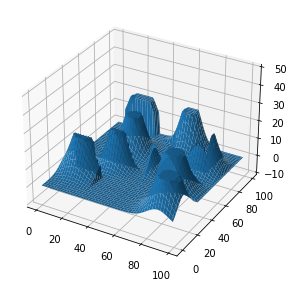

2/2


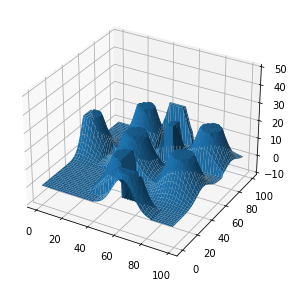

In [3]:
md.plot(n=2)

### (optional) more generate maps

In [ ]:
for _ in range(10):
    md.gen_gaussian_map_info()

In [ ]:
md.plot(n=len(md.map_list))

## Save the designated maps

In [ ]:
md.save()

# Load state and action information

In [3]:
import json

with open('json/state_ids.json', 'r') as f:
    state_ids = json.load(f)

with open('json/action_ids.json', 'r') as f:
    action_ids = json.load(f)
    
print(state_ids)
print(len(state_ids['field']))

num_states = 0
for state in state_ids.keys():
    if type(state_ids[state]) != int:
        num_states += len(state_ids[state])
    else:
        num_states += state_ids[state]
num_actions = len(action_ids)

print(num_states, num_actions)
print(action_ids)

{'field': {'0-19': 0, '20-39': 1, '40-59': 2, '60-79': 3, '80-100': 4}, 'wall': {'0-19': 5, '20-39': 6, '40-59': 7, '60-79': 8, '80-100': 9}, 'parachute': {'0-19': 10, '20-39': 11, '40-59': 12, '60-79': 13, '80-100': 14}, 'air': {'0-19': 15, '20-39': 16, '40-59': 17, '60-79': 18, '80-100': 19}, 'death': 20, 'goal': 21}
5
61 33
{'Wait': 0, 'W': 1, 'A': 2, 'S': 3, 'D': 4, 'WA': 5, 'WD': 6, 'SD': 7, 'SA': 8, 'Ws': 9, 'As': 10, 'Ss': 11, 'Ds': 12, 'WAs': 13, 'WDs': 14, 'SDs': 15, 'SAs': 16, 'Wj': 17, 'Aj': 18, 'Sj': 19, 'Dj': 20, 'WAj': 21, 'WDj': 22, 'SDj': 23, 'SAj': 24, 'Wsj': 25, 'Asj': 26, 'Ssj': 27, 'Dsj': 28, 'WAsj': 29, 'WDsj': 30, 'SDsj': 31, 'SAsj': 32}


In [4]:
from environment import *

In [5]:
# Agent(start_x=0.0, start_y=0.0, start_z=0.0, HP=100, stamina=100)
my_agent = Agent(stamina=200)

init_agent_dir = np.array([np.random.uniform(-1, 1), 0., np.random.uniform(-1, 1)])
init_agent_dir = norm(init_agent_dir)
print(init_agent_dir)
my_agent.dir = init_agent_dir

[ 0.09544524  0.         -0.99543468]


In [6]:
with open('pkl/data/my_agent.pkl', 'wb') as f:
    pickle.dump(my_agent, f)

In [7]:
with open('pkl/data/my_agent.pkl', 'rb') as f:
    my_agent = pickle.load(f)

# Set environment

In [8]:
goal_pos = np.array([50, md.map_list[0][50, 50], 50])
print(goal_pos)

[50.          0.09353686 50.        ]


In [9]:
# DO NOT modify the input parameters after constructing Environment.
my_env = Environment(agent=my_agent, map_info=md.map_list[0], goal_position=goal_pos,
            num_states=num_states, num_actions=num_actions,
            state_ids=state_ids, action_ids=action_ids,
            fall_damage=10, fall_min_height=6)

In [10]:
with open('pkl/data/my_env.pkl', 'wb') as f:
    pickle.dump(my_env, f)

In [11]:
with open('pkl/data/my_env.pkl', 'rb') as f:
    my_env = pickle.load(f)

In [12]:
trajectories = my_env.make_scenarios()

1
state:"field", action:"Wait", timestep:"0", reward:"0"
state:"field", action:"Wait", timestep:"0", reward:"-0.0"
state:"field", action:"Ds", timestep:"1", reward:"3.576182943025202"
state:"field", action:"SDs", timestep:"2", reward:"3.845942353250969"
2
state:"field", action:"Wait", timestep:"0", reward:"0"
state:"field", action:"Wait", timestep:"0", reward:"-0.0"
state:"field", action:"Ds", timestep:"1", reward:"3.576182943025202"
state:"field", action:"SDs", timestep:"2", reward:"3.845942353250969"
state:"field", action:"Wait", timestep:"0", reward:"0"
state:"field", action:"Wait", timestep:"0", reward:"-0.0"
state:"field", action:"Ds", timestep:"1", reward:"3.576182943025202"
state:"field", action:"SDs", timestep:"2", reward:"3.845942353250969"
3
state:"field", action:"Wait", timestep:"0", reward:"0"
state:"field", action:"Wait", timestep:"0", reward:"-0.0"
state:"field", action:"Ds", timestep:"1", reward:"3.576182943025202"
state:"field", action:"SDs", timestep:"2", reward:"3.845

In [11]:
print(len(trajectories))


9


## 잘 됐다고 가정  
my_env.dataset: list of scenarios. each scenario is list of [rtg, state.no, action.action_id]
rtg와 reward 둘 다 저장해야 할 수도 있음.

# Hyperparameters

In [ ]:
import argparse

parser = argparse.ArgumentParser()
#parser.add_argument('--env', type=str, default='hopper')
#parser.add_argument('--dataset', type=str, default='medium')  # medium, medium-replay, medium-expert, expert
parser.add_argument('--mode', type=str, default='normal')  # normal for standard setting, delayed for sparse
parser.add_argument('--K', type=int, default=20)
parser.add_argument('--pct_traj', type=float, default=1.)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--model_type', type=str, default='dt')  # dt for decision transformer, bc for behavior cloning
parser.add_argument('--embed_dim', type=int, default=128)
parser.add_argument('--n_layer', type=int, default=3)
parser.add_argument('--n_head', type=int, default=1)
parser.add_argument('--activation_function', type=str, default='relu')
parser.add_argument('--dropout', type=float, default=0.1)
parser.add_argument('--learning_rate', '-lr', type=float, default=1e-4)
parser.add_argument('--weight_decay', '-wd', type=float, default=1e-4)
parser.add_argument('--warmup_steps', type=int, default=10000)
parser.add_argument('--num_eval_episodes', type=int, default=100)
parser.add_argument('--max_iters', type=int, default=10)
parser.add_argument('--num_steps_per_iter', type=int, default=10000)
parser.add_argument('--device', type=str, default='cuda')
parser.add_argument('--log_to_wandb', '-w', type=bool, default=False)

args = parser.parse_args()
variant = vars(args)

In [ ]:
device = variant.get('device', 'cuda')

state_dim = 4           # State class의 instance 수
act_dim = 5             # Action class의 instance 수
max_ep_len = 500

K = variant['K']
batch_size = variant['batch_size']
num_eval_episodes = variant['num_eval_episodes']
pct_traj = variant.get('pct_traj', 1.)

scale = 10

states = []
for state in state_ids.keys():
    if type(state_ids[state]) != int:
        for val in state_ids[state]:
            states.append(val)
    else:
        states.append(state_ids[state])
        
states = np.concatenate(np.array(states), axis=0)
state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

## batch construction

In [ ]:
# save all path information into separate lists
mode = variant.get('mode', 'normal')
states, traj_lens, returns = [], [], []
for path in trajectories:
    if mode == 'delayed':  # delayed: all rewards moved to end of trajectory
        path['rewards'][-1] = path['rewards'].sum()
        path['rewards'][:-1] = 0.
    states.append(path['observations'])
    traj_lens.append(len(path['observations']))
    returns.append(path['rewards'].sum())
traj_lens, returns = np.array(traj_lens), np.array(returns)

# used for input normalization
states = np.concatenate(states, axis=0)
state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

num_timesteps = sum(traj_lens)
env_name = 'experiment1'

print('=' * 50)
print(f'Starting new experiment: {env_name}')
print(f'{len(traj_lens)} trajectories, {num_timesteps} timesteps found')
print(f'Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}')
print(f'Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}')
print('=' * 50)

K = variant['K']
batch_size = variant['batch_size']
num_eval_episodes = variant['num_eval_episodes']
pct_traj = variant.get('pct_traj', 1.)

# only train on top pct_traj trajectories (for %BC experiment)
num_timesteps = max(int(pct_traj*num_timesteps), 1)
sorted_inds = np.argsort(returns)  # lowest to highest
num_trajectories = 1
timesteps = traj_lens[sorted_inds[-1]]
ind = len(trajectories) - 2
while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
    timesteps += traj_lens[sorted_inds[ind]]
    num_trajectories += 1
    ind -= 1
sorted_inds = sorted_inds[-num_trajectories:]

# used to reweight sampling so we sample according to timesteps instead of trajectories
p_sample = traj_lens[sorted_inds] / sum(traj_lens[sorted_inds])

In [ ]:
import random

def discount_cumsum(x, gamma):
    discount_cumsum = np.zeros_like(x)
    discount_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0]-1)):
        discount_cumsum[t] = x[t] + gamma * discount_cumsum[t+1]
    return discount_cumsum

def get_batch(batch_size=256, max_len=K):
    # 
    batch_inds = np.random.choice(
        np.arange(num_trajectories),
        size=batch_size,
        replace=True,
        p=p_sample,  # reweights so we sample according to timesteps
    )
    s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
    for i in range(batch_size):
        traj = trajectories[int(sorted_inds[batch_inds[i]])] # one scene
        si = random.randint(0, traj['rewards'].shape[0] - 1)

        # get sequences from dataset
        s.append(traj['observations'][si:si + max_len].reshape(1, -1, state_dim))
        a.append(traj['actions'][si:si + max_len].reshape(1, -1, act_dim))
        r.append(traj['rewards'][si:si + max_len].reshape(1, -1, 1))
        if 'terminals' in traj:
            d.append(traj['terminals'][si:si + max_len].reshape(1, -1))
        else:
            d.append(traj['dones'][si:si + max_len].reshape(1, -1))
        timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
        timesteps[-1][timesteps[-1] >= max_ep_len] = max_ep_len-1  # padding cutoff
        rtg.append(discount_cumsum(traj['rewards'][si:], gamma=1.)[:s[-1].shape[1] + 1].reshape(1, -1, 1))  # calculate return-to-go
        if rtg[-1].shape[1] <= s[-1].shape[1]:
            rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

        # padding and state + reward normalization
        tlen = s[-1].shape[1]
        s[-1] = np.concatenate([np.zeros((1, max_len - tlen, state_dim)), s[-1]], axis=1)
        s[-1] = (s[-1] - state_mean) / state_std
        a[-1] = np.concatenate([np.ones((1, max_len - tlen, act_dim)) * -10., a[-1]], axis=1)
        r[-1] = np.concatenate([np.zeros((1, max_len - tlen, 1)), r[-1]], axis=1)
        d[-1] = np.concatenate([np.ones((1, max_len - tlen)) * 2, d[-1]], axis=1)
        rtg[-1] = np.concatenate([np.zeros((1, max_len - tlen, 1)), rtg[-1]], axis=1) / scale
        timesteps[-1] = np.concatenate([np.zeros((1, max_len - tlen)), timesteps[-1]], axis=1)
        mask.append(np.concatenate([np.zeros((1, max_len - tlen)), np.ones((1, tlen))], axis=1))

    s = torch.from_numpy(np.concatenate(s, axis=0)).to(dtype=torch.float32, device=device)
    a = torch.from_numpy(np.concatenate(a, axis=0)).to(dtype=torch.float32, device=device)
    r = torch.from_numpy(np.concatenate(r, axis=0)).to(dtype=torch.float32, device=device)
    d = torch.from_numpy(np.concatenate(d, axis=0)).to(dtype=torch.long, device=device)
    rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).to(dtype=torch.float32, device=device)
    timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).to(dtype=torch.long, device=device)
    mask = torch.from_numpy(np.concatenate(mask, axis=0)).to(device=device)

    return s, a, r, d, rtg, timesteps, mask

In [ ]:
from py.evaluate_episodes import *

# TODO: env=my_env에서, my_env를 arg로 받아서 차례대로 넘겨주게끔 작성
# target_rew 2개 당 1개의 env가 매핑되도록
def eval_episodes(target_rew, env):
    def fn(model):
        returns, lengths = [], []
        for _ in range(num_eval_episodes):
            with torch.no_grad():
                ret, length = evaluate_episode_rtg(
                    env=env,
                    state_dim=state_dim,
                    act_dim=act_dim,
                    model=model,
                    max_ep_len=max_ep_len,
                    scale=scale,
                    target_return=target_rew/scale,
                    mode=mode,
                    state_mean=state_mean,
                    state_std=state_std,
                    device=device,
                )
            returns.append(ret)
            lengths.append(length)
        return {
            f'target_{target_rew}_return_mean': np.mean(returns),
            f'target_{target_rew}_return_std': np.std(returns),
            f'target_{target_rew}_length_mean': np.mean(lengths),
            f'target_{target_rew}_length_std': np.std(lengths),
        }
    return fn

## Model construction

In [ ]:
from py.decision_transformer import DecisionTransformer

model = DecisionTransformer(
    state_dim=state_dim,
    act_dim=act_dim,
    max_length=K,
    max_ep_len=max_ep_len,
    hidden_size=variant['embed_dim'],
    n_layer=variant['n_layer'],
    n_head=variant['n_head'],
    n_inner=4*variant['embed_dim'],
    activation_function=variant['activation_function'],
    n_positions=1024,
    resid_pdrop=variant['dropout'],
    attn_pdrop=variant['dropout'],
)

model = model.to(device=device)
warmup_steps = variant['warmup_steps']
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=variant['learning_rate'],
    weight_decay=variant['weight_decay'],
)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda steps: min((steps+1)/warmup_steps, 1)
)

In [ ]:
from py.seq_trainer import SequenceTrainer

env_targets = [500, 256] # time steps to observe
len_env_targets = len(env_targets)
env_list = []
num_env = 1
for _ in range(num_env):
    # env = blabla
    for _ in range(len_env_targets):
        env_list.append(my_env)

trainer = SequenceTrainer(
    model=model,
    optimizer=optimizer,
    batch_size=batch_size,
    get_batch=get_batch,
    scheduler=scheduler,
    loss_fn=lambda s_hat, a_hat, r_hat, s, a, r: torch.mean((a_hat - a)**2),
    eval_fns=[eval_episodes(tar, env) for tar, env in zip(env_targets, env_list)],
)

# Learning

In [1]:
import wandb

log_to_wandb = variant.get('log_to_wandb', False)
exp_prefix = '3DPFg-experiment'
group_name = f'{exp_prefix}-{env_name}'     #f'{exp_prefix}-{env_name}-{dataset}'
exp_prefix = f'{group_name}-{random.randint(int(1e5), int(1e6) - 1)}'
if log_to_wandb:
    wandb.init(
        name=exp_prefix,
        group=group_name,
        project='decision-transformer',
        config=variant
    )
    # wandb.watch(model)  # wandb has some bug

for iter in range(variant['max_iters']):
    outputs = trainer.train_iteration(num_steps=variant['num_steps_per_iter'], iter_num=iter+1, print_logs=True)
    if log_to_wandb:
        wandb.log(outputs)

[[[0.]]]


# Evaluation
직접 predict를 찍어보면서 관찰하자  
이를테면, map_info를 N개 학습했을 때, 다른 test set map과 그에 상응하는 environment object들을 만들어 states, actions, rewards, rtg ... 를 구하여 action pred를 구하면 된다.

In [ ]:
# in decision_transformer.py,
# get_action(self, states, actions, rewards, returns_to_go, timesteps, **kwargs)

action_pred = model.get_action(states, actions, rewards, returns_to_go, timesteps)